# Survival Analysis: DirtSlurper3100

## Abstract

This report analyzes warranty data from the DirtSlurper3100 robot vacuum cleaner to characterize the lifetime of three critical components: the Battery, IR sensor, and Impact sensor. Using survival analysis techniques including Kaplan-Meier estimation, Cox proportional hazards modeling, and parametric Accelerated Failure Time (AFT) models, we evaluate whether these components meet manufacturer specifications. Key findings reveal that pet ownership is the strongest predictor of component failure (hazard ratio = 9.48), and we provide evidence-based recommendations regarding manufacturer warranty claims.

## Table of Contents

1. [Introduction](#introduction)
2. [Data Loading and Preprocessing](#data-loading)
3. [Exploratory Data Analysis](#eda)
4. [Modeling](#modeling)
   - 4.1 Kaplan-Meier Estimation
   - 4.2 Cox Proportional Hazards Model
   - 4.3 Proportional Hazards Assumption Check
   - 4.4 Parametric AFT Models
5. [Inference](#inference)
   - 5.1 Log-rank Tests for Group Comparisons
   - 5.2 L10 Estimates with Confidence Intervals
6. [Manufacturer Claims Verification](#manufacturer-claims)
7. [Conclusions and Recommendations](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, mannwhitneyu
from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.utils import median_survival_times
from datetime import datetime
import os

import warnings
warnings.filterwarnings("ignore")

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

<a id='introduction'></a>
## 1. Introduction

The DirtSlurper3100 is a robot vacuum cleaner manufactured by IButler. The company offers a 5-year limited warranty and has collected data from registered devices from January 2015 to December 2019. Management is concerned that warranty claims exceed expectations and seeks evidence to evaluate whether component suppliers meet their reliability specifications.

### Objectives

1. Characterize the lifetime distribution of three key components: Battery, IR sensor, and Impact sensor
2. Identify environmental and usage factors affecting component reliability
3. Verify manufacturer specifications:
   - **IR sensor**: L10 ≥ 2000 days
   - **Battery**: L10 ≥ 1000 days (excluding extreme usage >2400 hours)
   - **Impact sensor**: Provide specifications for potential external sales

### Censoring Mechanism

The data exhibits **Type I right censoring**: vacuum cleaners registered later in the study period have less opportunity to fail before the study ends (December 31, 2019). For non-failed units, we observe a lower bound on their lifetime, not the actual failure time.

<a id='data-loading'></a>
## 2. Data Loading and Preprocessing

In [2]:
df = pd.read_csv("Dataset.csv", sep=',')
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns")
print("\nColumn names and types:")
for column in df.columns:
    print(f"  {column:<25} {df[column].dtype}")

Dataset contains 6473 rows and 9 columns

Column names and types:
  Registration date         object
  Total usage time          int64
  Pets                      object
  Carpet score              int64
  Sent for repair           object
  Failure date              object
  Battery status            object
  Impact status             object
  IR status                 object


Registration dates in the dataset span from January 2015 to the end of December 2019. The `Registration date` column is currently stored as a string, which we convert to a standard datetime format to enable duration calculations and date filtering. We apply the same transformation to the `Failure date` column.

Additionally, we convert the `Pets` and `Sent for repair` columns from strings to binary values (0 = no, 1 = yes) for easier computation. Placeholder values (`---`) are replaced with `NaN` to properly represent missing data.

In [3]:
df.replace('---', np.nan, inplace=True)

df['Registration date'] = pd.to_datetime(df['Registration date'], format='%d%b%Y')
df["Failure date"] = df["Failure date"].replace("___", np.nan)
df["Failure date"] = pd.to_datetime(df["Failure date"], format='%d%b%Y', errors="coerce")

df["Pets"] = df["Pets"].map({"NO": 0, "YES": 1})
df["Sent for repair"] = df["Sent for repair"].map({"NO": 0, "YES": 1})
df["Battery status"] = df["Battery status"].map({"OK": 0, "Damage": 1})
df["Impact status"] = df["Impact status"].map({"OK": 0, "Damage": 1})
df["IR status"] = df["IR status"].map({"OK": 0, "Damage": 1})

df.head()

,Registration date,Total usage time,Pets,Carpet score,Sent for repair,Failure date,Battery status,Impact status,IR status
0,2019-07-29,233,0,5,0,NaT,NaN,NaN,NaN
1,2019-09-08,152,0,3,0,NaT,NaN,NaN,NaN
2,2016-06-06,475,0,2,1,2017-11-07,0.0,0.0,1.0
3,2019-02-25,326,0,4,0,NaT,NaN,NaN,NaN
4,2018-03-17,1018,1,4,0,NaT,NaN,NaN,NaN


In [4]:
censor_date = pd.to_datetime("31-12-2019", format="%d-%m-%Y")
df["Time"] = (df["Failure date"].fillna(censor_date) - df["Registration date"]).dt.days

print(f"Study period: {df['Registration date'].min().date()} to {censor_date.date()}")
print(f"Survival time range: {df['Time'].min()} to {df['Time'].max()} days")
df.head()

Study period: 2015-01-01 to 2019-12-31
Survival time range: 0 to 1825 days


,Registration date,Total usage time,Pets,Carpet score,Sent for repair,Failure date,Battery status,Impact status,IR status,Time
0,2019-07-29,233,0,5,0,NaT,NaN,NaN,NaN,155
1,2019-09-08,152,0,3,0,NaT,NaN,NaN,NaN,114
2,2016-06-06,475,0,2,1,2017-11-07,0.0,0.0,1.0,519
3,2019-02-25,326,0,4,0,NaT,NaN,NaN,NaN,309
4,2018-03-17,1018,1,4,0,NaT,NaN,NaN,NaN,654


### Data Cleaning and Assumptions

We apply the following data quality filters:
1. Remove vacuums sent for repair but with no damage to the three components of interest (likely other component failures)
2. Remove vacuums with multi-component failures (to isolate individual component reliability)

In [5]:
damaged = df[(df["Sent for repair"] == 1) & 
             ((df["Battery status"] == 0.0) & (df["Impact status"] == 0.0) & (df["IR status"] == 0.0))]
print(f"Vacuums sent for repair with no damage to Battery/Impact/IR: {len(damaged)}")

df = df.drop(damaged.index)
print(f"Remaining observations: {df.shape[0]}")

Vacuums sent for repair with no damage to Battery/Impact/IR: 64
Remaining observations: 6409


In [6]:
df["num_damaged"] = ((df["Battery status"] == 1.0).astype(int) + 
                      (df["Impact status"] == 1.0).astype(int) + 
                      (df["IR status"] == 1.0).astype(int))
multi_failures = df[df["num_damaged"] > 1]
print(f"Vacuums with multi-component failure: {len(multi_failures)}")

df = df.drop(multi_failures.index)
del df["num_damaged"]
print(f"Final dataset size: {df.shape[0]} observations")

Vacuums with multi-component failure: 2
Final dataset size: 6407 observations


In [7]:
df["UsageGroup"] = pd.cut(df["Total usage time"], 
                          bins=[0, 500, 1000, np.inf], 
                          labels=["Low", "Medium", "High"])

print("Usage group distribution:")
print(df["UsageGroup"].value_counts().sort_index())

Usage group distribution:
UsageGroup
Low       1745
Medium    1511
High      3147
Name: count, dtype: int64


<a id='eda'></a>
## 3. Exploratory Data Analysis

### Key Questions
- What is the distribution of total usage time?
- How many households have pets?
- What is the distribution of carpet scores?
- How many robots have been sent for repair?
- What are the component failure statuses for repaired robots?

In [8]:
print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Total vacuums: {len(df)}")
print(f"Sent for repair: {df['Sent for repair'].sum()} ({df['Sent for repair'].mean()*100:.1f}%)")
print(f"Households with pets: {df['Pets'].sum()} ({df['Pets'].mean()*100:.1f}%)")
print(f"\nTotal usage time (hours):")
print(f"  Mean: {df['Total usage time'].mean():.1f}")
print(f"  Median: {df['Total usage time'].median():.1f}")
print(f"  Std: {df['Total usage time'].std():.1f}")
print(f"\nCarpet score distribution:")
print(df['Carpet score'].value_counts().sort_index())

DATASET SUMMARY
Total vacuums: 6407
Sent for repair: 1048 (16.4%)
Households with pets: 2605 (40.7%)

Total usage time (hours):
  Mean: 1091.7
  Median: 983.0
  Std: 763.5

Carpet score distribution:
Carpet score
1     497
2    1555
3    1931
4    1361
5     723
6     245
7      82
8      13
Name: count, dtype: int64


In [9]:
df_sent_repair = df[df['Sent for repair'] == 1]
df_not_repair = df[df['Sent for repair'] == 0]

print(f"Sent for repair: {len(df_sent_repair)}")
print(f"Not sent for repair: {len(df_not_repair)}")

Sent for repair: 1048
Not sent for repair: 5359


In [10]:
print("\nComponent failures among repaired units:")
print(f"  Battery failures: {df_sent_repair['Battery status'].sum():.0f}")
print(f"  IR sensor failures: {df_sent_repair['IR status'].sum():.0f}")
print(f"  Impact sensor failures: {df_sent_repair['Impact status'].sum():.0f}")


Component failures among repaired units:
  Battery failures: 677
  IR sensor failures: 282
  Impact sensor failures: 89


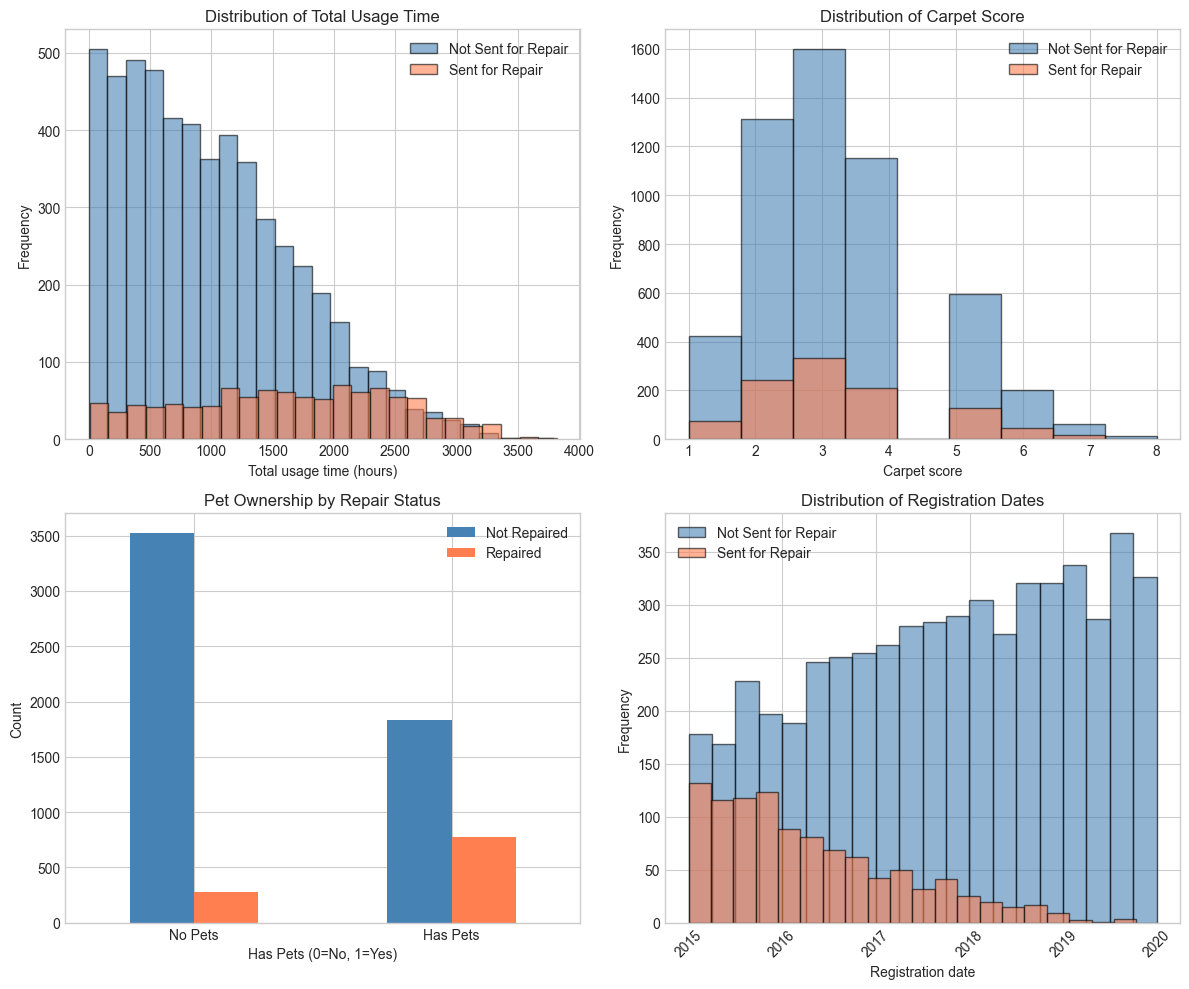

In [11]:
# Comparative visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Total usage time distribution
ax1 = axes[0, 0]
ax1.hist(df_not_repair['Total usage time'], bins=25, alpha=0.6, 
         label='Not Sent for Repair', color='steelblue', edgecolor='black')
ax1.hist(df_sent_repair['Total usage time'], bins=25, alpha=0.6, 
         label='Sent for Repair', color='coral', edgecolor='black')
ax1.set_title('Distribution of Total Usage Time')
ax1.set_xlabel('Total usage time (hours)')
ax1.set_ylabel('Frequency')
ax1.legend()

# Carpet score distribution
ax2 = axes[0, 1]
ax2.hist(df_not_repair['Carpet score'], bins=9, alpha=0.6, 
         label='Not Sent for Repair', color='steelblue', edgecolor='black')
ax2.hist(df_sent_repair['Carpet score'], bins=9, alpha=0.6, 
         label='Sent for Repair', color='coral', edgecolor='black')
ax2.set_title('Distribution of Carpet Score')
ax2.set_xlabel('Carpet score')
ax2.set_ylabel('Frequency')
ax2.legend()

# Pet ownership comparison
ax3 = axes[1, 0]
pet_data = pd.DataFrame({
    'Not Repaired': df_not_repair['Pets'].value_counts().sort_index(),
    'Repaired': df_sent_repair['Pets'].value_counts().sort_index()
})
pet_data.plot(kind='bar', ax=ax3, color=['steelblue', 'coral'])
ax3.set_title('Pet Ownership by Repair Status')
ax3.set_xlabel('Has Pets (0=No, 1=Yes)')
ax3.set_ylabel('Count')
ax3.set_xticklabels(['No Pets', 'Has Pets'], rotation=0)

# Registration date distribution
ax4 = axes[1, 1]
ax4.hist(df_not_repair['Registration date'], bins=20, alpha=0.6, 
         label='Not Sent for Repair', color='steelblue', edgecolor='black')
ax4.hist(df_sent_repair['Registration date'], bins=20, alpha=0.6, 
         label='Sent for Repair', color='coral', edgecolor='black')
ax4.set_title('Distribution of Registration Dates')
ax4.set_xlabel('Registration date')
ax4.set_ylabel('Frequency')
ax4.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### EDA Observations

The total usage time of vacuum cleaners not sent for repair appears to follow a decreasing linear pattern, whereas vacuum cleaners sent for repair exhibit a more stable distribution with a more central mean and tighter interquartile range. This suggests that total usage time may be a significant factor.

Furthermore, households with pets appear more likely to have sent their vacuum for repair, indicating that pet ownership may be a significant factor.

The distribution of registration dates shows that vacuums not sent for repair have linearly increasing registrations over time, while vacuums sent for repair exhibit linearly decreasing registrations. Given the Type I right censoring in our data, this is expected: vacuums registered more recently have not had sufficient usage time to experience failure.

### Statistical Tests for Factor Associations

We test whether total usage time, pet ownership, and carpet score are significantly associated with repair status using appropriate statistical tests:
- **Continuous variables** (Total usage time, Carpet score): Mann-Whitney U test
- **Categorical variables** (Pets): Chi-square test of independence

STATISTICAL TESTS: Factors vs Repair Decision

Total usage time:
  Test: Mann-Whitney U
  U statistic: 1606817.0
  p-value: 1.18e-106
  Result: Significant (α=0.05)

Pets:
  Test: Chi-square
  Chi2 statistic: 570.63
  p-value: 4.10e-126
  Result: Significant (α=0.05)

Carpet score:
  Test: Mann-Whitney U
  U statistic: 2743667.0
  p-value: 2.26e-01
  Result: Not significant (α=0.05)


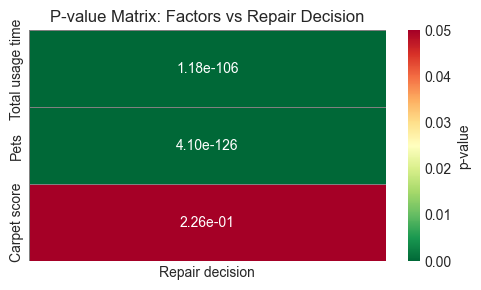

In [12]:
# Statistical tests for factor associations with repair decision
factors = ['Total usage time', 'Pets', 'Carpet score']
p_matrix = pd.DataFrame(index=factors, columns=["Repair decision"], dtype=float)

print("STATISTICAL TESTS: Factors vs Repair Decision")
print("="*70)

for factor in factors:
    if factor in ['Total usage time', 'Carpet score']:  # Continuous - Mann Whitney U
        group1 = df_not_repair[factor]
        group2 = df_sent_repair[factor]
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
        p_matrix.loc[factor, "Repair decision"] = p
        
        print(f"\n{factor}:")
        print(f"  Test: Mann-Whitney U")
        print(f"  U statistic: {stat:.1f}")
        print(f"  p-value: {p:.2e}")
        print(f"  Result: {'Significant' if p < 0.05 else 'Not significant'} (α=0.05)")
    else:  # Categorical - Chi-square
        contingency = pd.crosstab(df[factor], df['Sent for repair'])
        chi2, p, dof, expected = chi2_contingency(contingency)
        p_matrix.loc[factor, "Repair decision"] = p
        
        print(f"\n{factor}:")
        print(f"  Test: Chi-square")
        print(f"  Chi2 statistic: {chi2:.2f}")
        print(f"  p-value: {p:.2e}")
        print(f"  Result: {'Significant' if p < 0.05 else 'Not significant'} (α=0.05)")

# Visualize p-values
plt.figure(figsize=(5, 3))
sns.heatmap(p_matrix.astype(float), annot=True, fmt=".2e", cmap="RdYlGn_r", 
            cbar_kws={'label': 'p-value'}, linewidths=0.5, linecolor='gray',
            vmin=0, vmax=0.05)
plt.title("P-value Matrix: Factors vs Repair Decision")
plt.tight_layout()
plt.show()

### Conditional Analysis: Factors vs Component Status

We test whether total usage time, pet ownership, and carpet score are significantly associated with each component's failure status (Battery, Impact, IR) — resulting in 9 tests.

**Note on Multiple Testing**: With 9 tests, we apply a Bonferroni correction. The adjusted significance level is α = 0.05/9 ≈ 0.0056.

Bonferroni-corrected significance level: α = 0.0056

P-value Matrix:
                  Battery status  Impact status     IR status
Total usage time    2.331698e-32   7.142676e-30  3.515895e-88
Pets                2.202763e-40   6.614977e-03  1.526564e-58
Carpet score        4.877131e-05   8.730264e-12  6.395191e-01


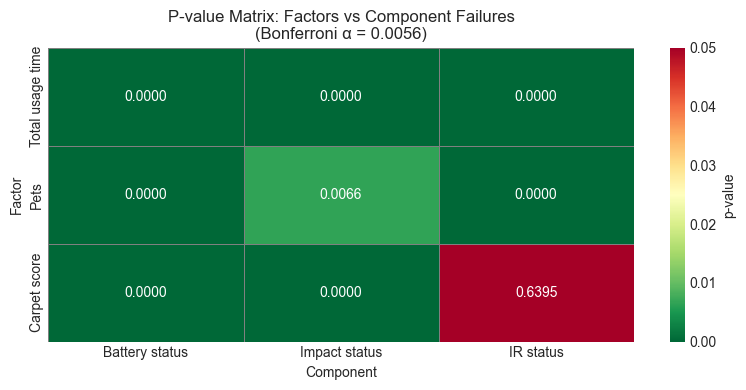


Significant associations (after Bonferroni correction):
  ✓ Total usage time ↔ Battery status (p = 2.33e-32)
  ✓ Total usage time ↔ Impact status (p = 7.14e-30)
  ✓ Total usage time ↔ IR status (p = 3.52e-88)
  ✓ Pets ↔ Battery status (p = 2.20e-40)
  ~ Pets ↔ Impact status (p = 0.0066, significant without correction)
  ✓ Pets ↔ IR status (p = 1.53e-58)
  ✓ Carpet score ↔ Battery status (p = 4.88e-05)
  ✓ Carpet score ↔ Impact status (p = 8.73e-12)


In [13]:
# Multiple testing correction
n_tests = 9
alpha = 0.05
bonferroni_alpha = alpha / n_tests
print(f"Bonferroni-corrected significance level: α = {bonferroni_alpha:.4f}")
print("="*70)

factors = ['Total usage time', 'Pets', 'Carpet score']
components = ['Battery status', 'Impact status', 'IR status']
p_matrix = pd.DataFrame(index=factors, columns=components, dtype=float)

for factor in factors:
    for component in components:
        if factor == 'Total usage time':  # Continuous - Mann Whitney U
            group1 = df_sent_repair.loc[df_sent_repair[component] == 0, factor]
            group2 = df_sent_repair.loc[df_sent_repair[component] == 1, factor]
            if len(group1) > 0 and len(group2) > 0:
                stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
            else:
                p = np.nan
        else:  # Categorical - Chi-square
            contingency = pd.crosstab(df_sent_repair[factor], df_sent_repair[component])
            chi2, p, dof, expected = chi2_contingency(contingency)
        
        p_matrix.loc[factor, component] = p

# Display results
print("\nP-value Matrix:")
print(p_matrix.to_string())

# Visualize
plt.figure(figsize=(8, 4))
sns.heatmap(p_matrix.astype(float), annot=True, fmt=".4f", cmap="RdYlGn_r", 
            cbar_kws={'label': 'p-value'}, linewidths=0.5, linecolor='gray',
            vmin=0, vmax=0.05)
plt.title(f"P-value Matrix: Factors vs Component Failures\n(Bonferroni α = {bonferroni_alpha:.4f})")
plt.xlabel("Component")
plt.ylabel("Factor")
plt.tight_layout()
plt.show()

# Summary of significant associations
print("\nSignificant associations (after Bonferroni correction):")
for factor in factors:
    for component in components:
        p = p_matrix.loc[factor, component]
        if p < bonferroni_alpha:
            print(f"  ✓ {factor} ↔ {component} (p = {p:.2e})")
        elif p < alpha:
            print(f"  ~ {factor} ↔ {component} (p = {p:.4f}, significant without correction)")

### EDA Conclusions

These findings indicate that total usage time and pet ownership are significantly associated with most component statuses. The relationship between carpet score and IR status shows no significant association, even without multiple testing correction.

<a id='modeling'></a>
## 4. Modeling

The primary objective is to characterize the lifetime of three key components. Component lifetimes may depend on various factors, including environmental properties (pet ownership, carpet score) and usage intensity (total cleaning time).

### Modeling Approach

1. **Kaplan-Meier Estimation**: Non-parametric baseline survival curves
2. **Cox Proportional Hazards**: Semi-parametric model to quantify covariate effects
3. **Parametric AFT Models**: Weibull, Log-Normal, Log-Logistic for L10 estimation

In [14]:
# Fill NaN status values with 0 (not failed) for non-repaired units
cols = ['Battery status', 'Impact status', 'IR status']
df[cols] = df[cols].fillna(0)
df.head()

,Registration date,Total usage time,Pets,Carpet score,Sent for repair,Failure date,Battery status,Impact status,IR status,Time,UsageGroup
0,2019-07-29,233,0,5,0,NaT,0.0,0.0,0.0,155,Low
1,2019-09-08,152,0,3,0,NaT,0.0,0.0,0.0,114,Low
2,2016-06-06,475,0,2,1,2017-11-07,0.0,0.0,1.0,519,Low
3,2019-02-25,326,0,4,0,NaT,0.0,0.0,0.0,309,Low
4,2018-03-17,1018,1,4,0,NaT,0.0,0.0,0.0,654,High


### 4.1 Kaplan-Meier Estimation

We implement a Kaplan-Meier estimator for each component (Battery, Impact sensor, IR sensor). The Kaplan-Meier estimator provides a non-parametric estimate of the survival function, allowing us to determine the probability that a component survives beyond a given time while accounting for right-censored observations.

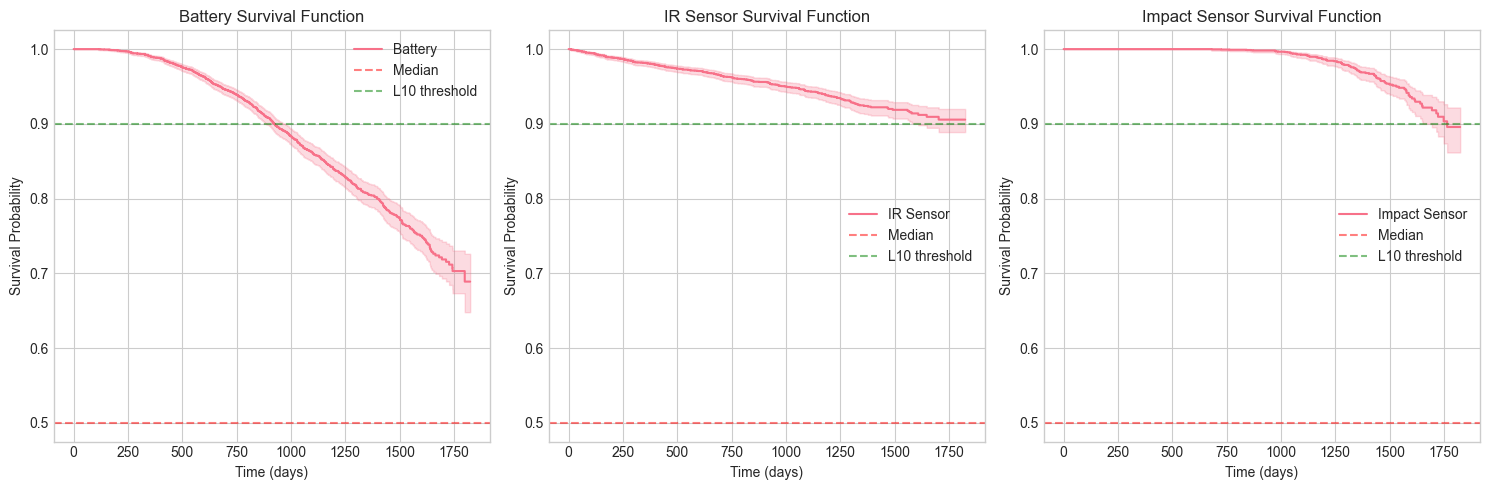


Kaplan-Meier Summary:
--------------------------------------------------
Battery:
  Events (failures): 677
  Censored: 5730
  Median survival: Not reached
IR Sensor:
  Events (failures): 282
  Censored: 6125
  Median survival: Not reached
Impact Sensor:
  Events (failures): 89
  Censored: 6318
  Median survival: Not reached


In [15]:
# Kaplan-Meier estimation for each component
kmf = KaplanMeierFitter()

components = {
    "Battery": "Battery status",
    "IR Sensor": "IR status",
    "Impact Sensor": "Impact status"
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

km_results = {}

for ax, (name, col) in zip(axes, components.items()):
    kmf.fit(df["Time"], df[col], label=name)
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Store results
    median_survival = kmf.median_survival_time_
    km_results[name] = {
        'median': median_survival,
        'events': df[col].sum(),
        'censored': len(df) - df[col].sum()
    }
    
    ax.set_title(f'{name} Survival Function')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Survival Probability')
    ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Median')
    ax.axhline(y=0.9, color='g', linestyle='--', alpha=0.5, label='L10 threshold')
    ax.legend()

plt.tight_layout()
plt.show()

# Print summary
print("\nKaplan-Meier Summary:")
print("-"*50)
for name, results in km_results.items():
    median_str = f"{results['median']:.0f} days" if np.isfinite(results['median']) else "Not reached"
    print(f"{name}:")
    print(f"  Events (failures): {results['events']:.0f}")
    print(f"  Censored: {results['censored']:.0f}")
    print(f"  Median survival: {median_str}")

### 4.2 Cox Proportional Hazards Model

Our exploratory analysis revealed that several factors — notably total usage time and pet ownership — are significantly associated with vacuum failure. To model the relationship between these covariates and component lifetimes, we implement a Cox proportional hazards model. This semi-parametric approach allows us to estimate hazard ratios for each covariate without assuming a specific baseline hazard distribution.

Cox Proportional Hazards Model Results


<lifelines.CoxPHFitter: fitted with 6407 total observations, 5359 right-censored observations>
             duration col = 'Time'
                event col = 'Sent for repair'
      baseline estimation = breslow
   number of observations = 6407
number of events observed = 1048
   partial log-likelihood = -7783.745
         time fit was run = 2025-12-11 15:32:45 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
Pets              2.250     9.484     0.079           2.095           2.404               8.123              11.071
Carpet score      0.042     1.043     0.023          -0.003           0.088               0.997               1.092
Total usage time -0.001     0.999     0.000          -0.001          -0.001               0.999               0.999

                  cmp to       z       p  -log2(p)
covariate                                         
Pets               0.000  28.481 <0.0005   590.301
Carpet score       0.000   1.825   0.068     3.878
Total usage time   0.000 -13.526 <0.0005   136.069
---
Concordance = 0.796
Partial AIC = 15573.491
log-likelihood ratio test = 895.661 on 3 df
-log2(p) of ll-ratio test = 641.504

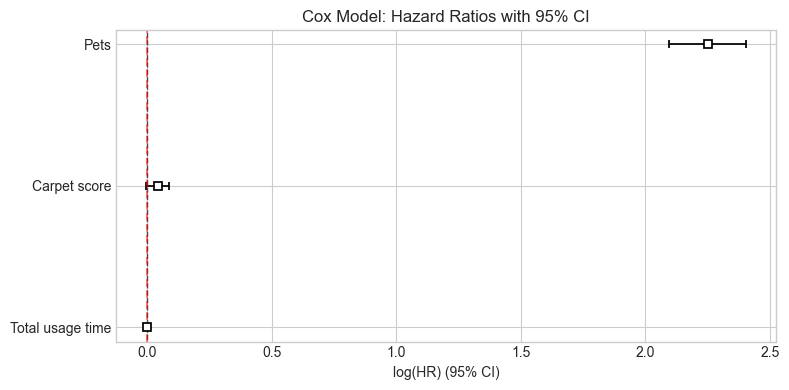

In [16]:
# Cox Proportional Hazards Model
cph = CoxPHFitter()

# Prepare data
cox_data = df[["Time", "Sent for repair", "Pets", "Carpet score", "Total usage time"]].dropna()

# Fit model
cph.fit(cox_data, duration_col="Time", event_col="Sent for repair")

# Print summary
print("Cox Proportional Hazards Model Results")
print("="*60)
cph.print_summary(decimals=3)

# Plot hazard ratios
fig, ax = plt.subplots(figsize=(8, 4))
cph.plot(ax=ax)
ax.set_title("Cox Model: Hazard Ratios with 95% CI")
ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### Cox Model Interpretation

The hazard ratio (HR) indicates how much the hazard (instantaneous failure rate) changes for a one-unit increase in the covariate:
- **HR > 1**: Increased hazard (shorter survival)
- **HR < 1**: Decreased hazard (longer survival)
- **HR = 1**: No effect

### 4.3 Proportional Hazards Assumption Check

The Cox model assumes that hazard ratios remain constant over time (proportional hazards). We verify this assumption using Schoenfeld residuals test.

Proportional Hazards Assumption Test
H0: Hazard ratios are constant over time (PH assumption holds)
H1: Hazard ratios vary over time (PH assumption violated)


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 6407 total observations, 5359 right-censored observations>
         test_name = proportional_hazard_test

---
                       test_statistic      p  -log2(p)
Carpet score     km              0.55   0.46      1.12
                 rank            0.00   0.99      0.02
Pets             km             23.79 <0.005     19.83
                 rank           18.23 <0.005     15.64
Total usage time km            336.03 <0.005    246.92
                 rank          364.01 <0.005    267.16



1. Variable 'Pets' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Pets', ...]` in the call in
`.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


2. Variable 'Total usage time' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'Total usage time' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Total usage time' using pd.cut, and then specify it in
`strata=['Total usage time', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
bel

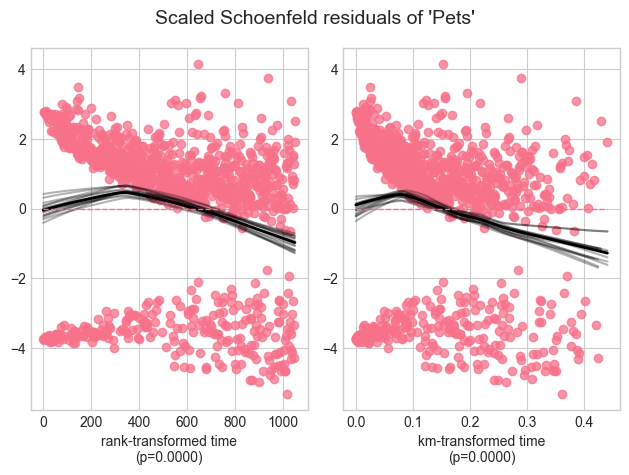

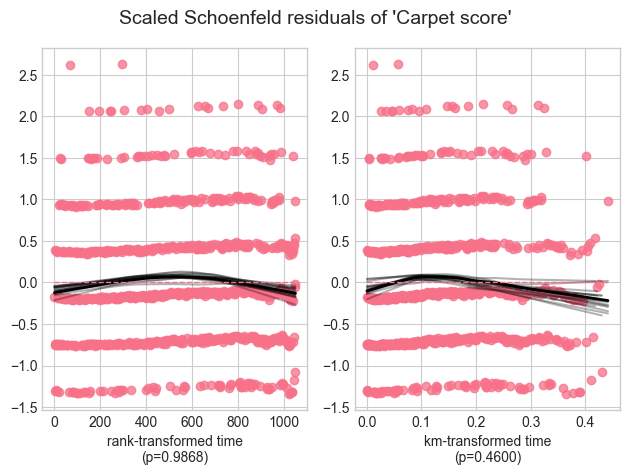

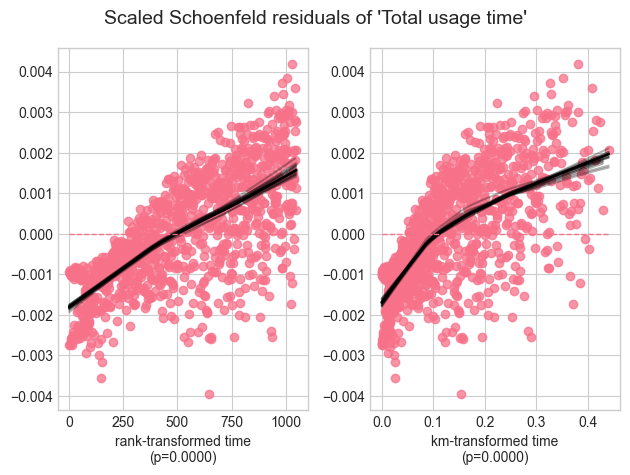

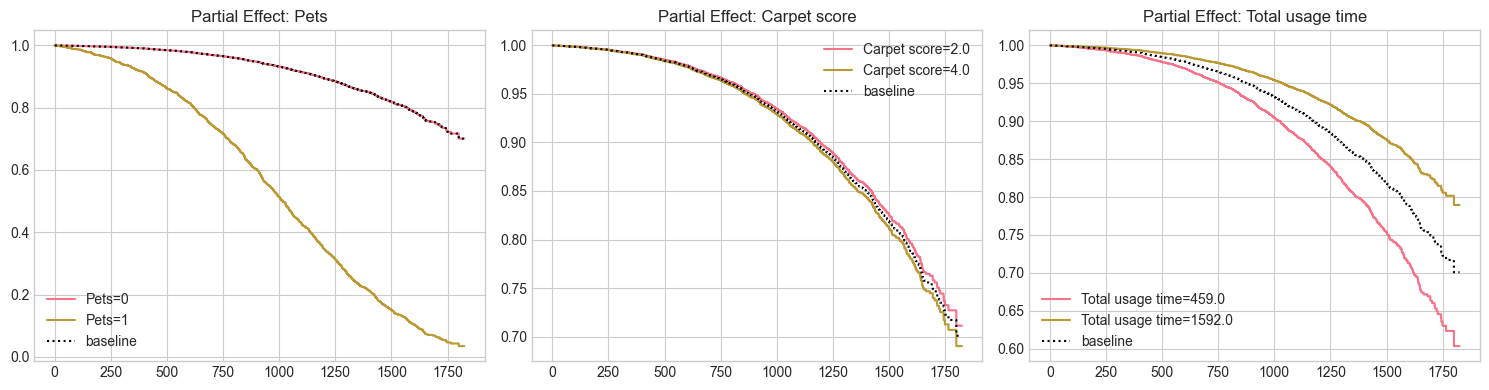

In [17]:
# Check proportional hazards assumption
print("Proportional Hazards Assumption Test")
print("="*60)
print("H0: Hazard ratios are constant over time (PH assumption holds)")
print("H1: Hazard ratios vary over time (PH assumption violated)")
print()

try:
    # Test the assumption
    results = cph.check_assumptions(cox_data, p_value_threshold=0.05, show_plots=True)
except Exception as e:
    print(f"Note: {e}")
    print("\nAlternative: Visual inspection of Schoenfeld residuals")
    
# Plot Schoenfeld residuals
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, covariate in zip(axes, ['Pets', 'Carpet score', 'Total usage time']):
    try:
        cph.plot_partial_effects_on_outcome(covariate, [0, 1] if covariate == 'Pets' else 
                                            [df[covariate].quantile(0.25), df[covariate].quantile(0.75)],
                                            ax=ax)
        ax.set_title(f'Partial Effect: {covariate}')
    except:
        ax.set_title(f'{covariate}: Unable to plot')
plt.tight_layout()
plt.show()

### 4.4 Parametric AFT Models

To obtain L10 estimates (10th percentile of lifetime distribution), we fit parametric Accelerated Failure Time (AFT) models. We compare Weibull, Log-Normal, and Log-Logistic distributions using AIC.


Component: Battery
Adjusted 4 non-positive usage values to 0.001
Sample size: n = 6407
Events: 677

AIC Comparison:
  Weibull: 12433.74 ← Best
  Log-logistic: 12463.09
  Log-normal: 12573.80


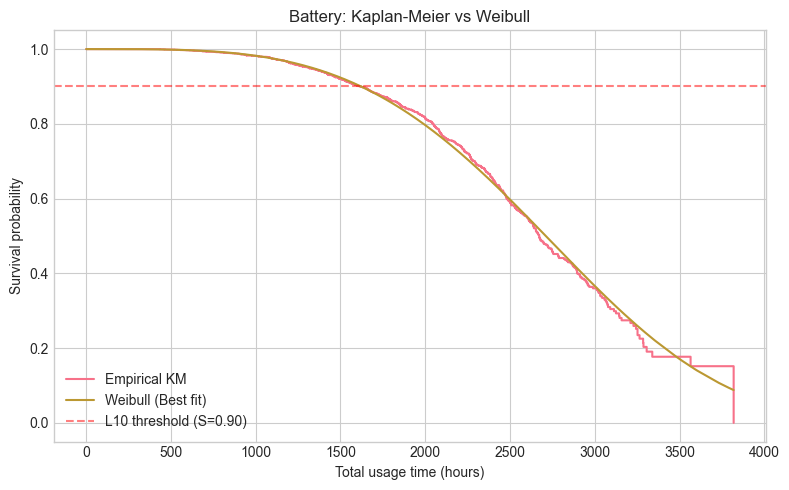


Component: IR
Adjusted 4 non-positive usage values to 0.001
Sample size: n = 6407
Events: 282

AIC Comparison:
  Log-normal: 6269.44 ← Best
  Log-logistic: 6272.02
  Weibull: 6272.64


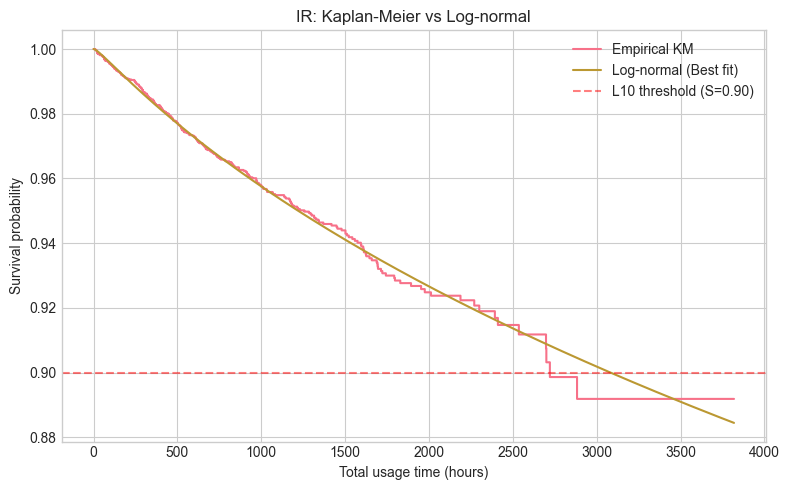


Component: Impact
Adjusted 4 non-positive usage values to 0.001
Sample size: n = 6407
Events: 89

AIC Comparison:
  Weibull: 1674.10 ← Best
  Log-logistic: 1675.16
  Log-normal: 1692.16


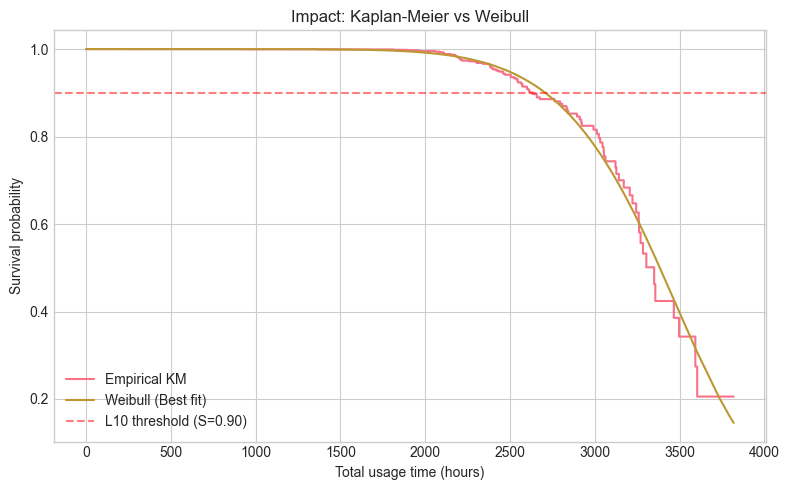

In [18]:
# Parametric AFT model comparison for each component
components = {
    "Battery": "Battery status",
    "IR": "IR status",
    "Impact": "Impact status"
}

OUT = "dist_plots"
os.makedirs(OUT, exist_ok=True)
kmf = KaplanMeierFitter()
EPS = 1e-3

aft_results = {}

for comp, evt in components.items():
    print(f"\n{'='*60}")
    print(f"Component: {comp}")
    print(f"{'='*60}")
    
    dsub = df[["Total usage time", evt]].dropna().copy()
    
    # Handle non-positive values
    n0 = int((dsub["Total usage time"] <= 0).sum())
    if n0 > 0:
        print(f"Adjusted {n0} non-positive usage values to {EPS}")
        dsub.loc[dsub["Total usage time"] <= 0, "Total usage time"] = EPS
    
    print(f"Sample size: n = {len(dsub)}")
    print(f"Events: {dsub[evt].sum():.0f}")
    
    # Fit models
    wb = WeibullAFTFitter().fit(dsub, "Total usage time", event_col=evt)
    ln = LogNormalAFTFitter().fit(dsub, "Total usage time", event_col=evt)
    ll = LogLogisticAFTFitter().fit(dsub, "Total usage time", event_col=evt)
    
    # Compare AIC
    aics = {"Weibull": wb.AIC_, "Log-normal": ln.AIC_, "Log-logistic": ll.AIC_}
    best = min(aics, key=aics.get)
    
    print(f"\nAIC Comparison:")
    for name, aic in sorted(aics.items(), key=lambda x: x[1]):
        marker = " ← Best" if name == best else ""
        print(f"  {name}: {aic:.2f}{marker}")
    
    # Store best model
    if best == "Weibull":
        model = wb
    elif best == "Log-normal":
        model = ln
    else:
        model = ll
    
    aft_results[comp] = {'model': model, 'best': best, 'aics': aics}
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(8, 5))
    kmf.fit(dsub["Total usage time"], dsub[evt], label="Empirical KM").plot(ax=ax, ci_show=False)
    model.predict_survival_function(dsub).mean(axis=1).plot(ax=ax, label=f"{best} (Best fit)")
    ax.set_title(f"{comp}: Kaplan-Meier vs {best}")
    ax.set_xlabel("Total usage time (hours)")
    ax.set_ylabel("Survival probability")
    ax.axhline(y=0.9, color='r', linestyle='--', alpha=0.5, label='L10 threshold (S=0.90)')
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(OUT, f"{comp}_KM_vs_{best}.png"), dpi=160)
    plt.show()

<a id='inference'></a>
## 5. Inference

### 5.1 Log-rank Tests for Group Comparisons

We formally test whether survival curves differ significantly between groups (e.g., pet owners vs non-pet owners) using log-rank tests.

In [19]:
# Log-rank tests for survival curve comparisons
print("LOG-RANK TESTS: Survival Curve Comparisons")
print("="*70)

components = {
    "Battery": "Battery status",
    "IR Sensor": "IR status",
    "Impact Sensor": "Impact status"
}

# Test by Pet ownership
print("\n--- By Pet Ownership ---")
for name, col in components.items():
    group_no_pets = df[df['Pets'] == 0]
    group_pets = df[df['Pets'] == 1]
    
    results = logrank_test(
        group_no_pets['Time'], group_pets['Time'],
        group_no_pets[col], group_pets[col]
    )
    
    sig = "*" if results.p_value < 0.05 else ""
    print(f"{name}: χ² = {results.test_statistic:.2f}, p = {results.p_value:.4f} {sig}")

# Test by Usage Group
print("\n--- By Usage Group (multivariate) ---")
for name, col in components.items():
    results = multivariate_logrank_test(
        df['Time'], df['UsageGroup'], df[col]
    )
    
    sig = "*" if results.p_value < 0.05 else ""
    print(f"{name}: χ² = {results.test_statistic:.2f}, p = {results.p_value:.4f} {sig}")

print("\n* indicates p < 0.05")

LOG-RANK TESTS: Survival Curve Comparisons

--- By Pet Ownership ---
Battery: χ² = 877.06, p = 0.0000 *
IR Sensor: χ² = 0.07, p = 0.7886 
Impact Sensor: χ² = 169.23, p = 0.0000 *

--- By Usage Group (multivariate) ---
Battery: χ² = 48.48, p = 0.0000 *
IR Sensor: χ² = 510.28, p = 0.0000 *
Impact Sensor: χ² = 8.43, p = 0.0380 *

* indicates p < 0.05


### 5.2 L10 Estimates with Confidence Intervals

L10 is the time at which 10% of units have failed (equivalently, 90% survive). This is a key reliability metric. We compute L10 estimates with confidence intervals using bootstrap resampling.

In [20]:
def compute_l10_with_ci(df, time_col, event_col, n_bootstrap=1000, random_state=42):
    """Compute L10 with bootstrap confidence intervals."""
    np.random.seed(random_state)
    
    kmf = KaplanMeierFitter()
    
    # Point estimate
    kmf.fit(df[time_col], df[event_col])
    
    # Find L10 (time when S(t) = 0.90)
    try:
        survival_func = kmf.survival_function_
        l10_idx = (survival_func['KM_estimate'] <= 0.90).idxmax()
        l10_point = l10_idx
    except:
        l10_point = np.nan
    
    # Bootstrap for CI
    l10_bootstrap = []
    n = len(df)
    
    for _ in range(n_bootstrap):
        boot_idx = np.random.choice(n, size=n, replace=True)
        boot_df = df.iloc[boot_idx]
        
        try:
            kmf_boot = KaplanMeierFitter()
            kmf_boot.fit(boot_df[time_col], boot_df[event_col])
            survival_func = kmf_boot.survival_function_
            l10_idx = (survival_func['KM_estimate'] <= 0.90).idxmax()
            l10_bootstrap.append(l10_idx)
        except:
            pass
    
    if len(l10_bootstrap) > 0:
        l10_ci_lower = np.percentile(l10_bootstrap, 2.5)
        l10_ci_upper = np.percentile(l10_bootstrap, 97.5)
    else:
        l10_ci_lower = np.nan
        l10_ci_upper = np.nan
    
    return l10_point, l10_ci_lower, l10_ci_upper

# Compute L10 for each component
print("L10 ESTIMATES WITH 95% CONFIDENCE INTERVALS")
print("="*70)
print("(L10 = time at which 10% of units have failed)")
print()

l10_results = {}

for name, col in components.items():
    l10, ci_lower, ci_upper = compute_l10_with_ci(df, 'Time', col, n_bootstrap=500)
    l10_results[name] = {'L10': l10, 'CI_lower': ci_lower, 'CI_upper': ci_upper}
    
    if np.isfinite(l10):
        print(f"{name}:")
        print(f"  L10 = {l10:.0f} days (95% CI: [{ci_lower:.0f}, {ci_upper:.0f}])")
    else:
        print(f"{name}:")
        print(f"  L10 = Not reached within observation period")

L10 ESTIMATES WITH 95% CONFIDENCE INTERVALS
(L10 = time at which 10% of units have failed)

Battery:
  L10 = 923 days (95% CI: [888, 975])
IR Sensor:
  L10 = 0 days (95% CI: [0, 1703])
Impact Sensor:
  L10 = 1765 days (95% CI: [0, 1765])


In [21]:
# Stratified L10 analysis by key factors
print("\nSTRATIFIED L10 ANALYSIS")
print("="*70)

# By pet ownership
print("\n--- By Pet Ownership ---")
for name, col in components.items():
    print(f"\n{name}:")
    for pet_status, label in [(0, "No Pets"), (1, "Has Pets")]:
        subset = df[df['Pets'] == pet_status]
        l10, ci_lower, ci_upper = compute_l10_with_ci(subset, 'Time', col, n_bootstrap=200)
        
        if np.isfinite(l10):
            print(f"  {label}: L10 = {l10:.0f} days (95% CI: [{ci_lower:.0f}, {ci_upper:.0f}])")
        else:
            print(f"  {label}: L10 not reached")

# By usage group
print("\n--- By Usage Group ---")
for name, col in components.items():
    print(f"\n{name}:")
    for usage in ['Low', 'Medium', 'High']:
        subset = df[df['UsageGroup'] == usage]
        if len(subset) > 50:  # Ensure sufficient sample size
            l10, ci_lower, ci_upper = compute_l10_with_ci(subset, 'Time', col, n_bootstrap=200)
            
            if np.isfinite(l10):
                print(f"  {usage} usage: L10 = {l10:.0f} days (95% CI: [{ci_lower:.0f}, {ci_upper:.0f}])")
            else:
                print(f"  {usage} usage: L10 not reached")
        else:
            print(f"  {usage} usage: Insufficient data")


STRATIFIED L10 ANALYSIS

--- By Pet Ownership ---

Battery:
  No Pets: L10 = 1744 days (95% CI: [0, 1744])
  Has Pets: L10 = 626 days (95% CI: [597, 661])

IR Sensor:
  No Pets: L10 = 0 days (95% CI: [0, 1703])
  Has Pets: L10 = 1648 days (95% CI: [0, 1648])

Impact Sensor:
  No Pets: L10 = 0 days (95% CI: [0, 0])
  Has Pets: L10 = 1390 days (95% CI: [1335, 1476])

--- By Usage Group ---

Battery:
  Low usage: L10 = 0 days (95% CI: [0, 0])
  Medium usage: L10 = 1622 days (95% CI: [0, 1622])
  High usage: L10 = 864 days (95% CI: [824, 909])

IR Sensor:
  Low usage: L10 = 411 days (95% CI: [334, 520])
  Medium usage: L10 = 1151 days (95% CI: [1059, 1311])
  High usage: L10 = 0 days (95% CI: [0, 0])

Impact Sensor:
  Low usage: L10 = 0 days (95% CI: [0, 0])
  Medium usage: L10 = 0 days (95% CI: [0, 0])
  High usage: L10 = 1749 days (95% CI: [0, 1765])


<a id='manufacturer-claims'></a>
## 6. Manufacturer Claims Verification

We now directly address the manufacturer specifications provided in the project brief.

In [22]:
print("="*70)
print("MANUFACTURER CLAIMS VERIFICATION")
print("="*70)

# IR Sensor Claim: L10 >= 2000 days
print("\n" + "-"*70)
print("IR SENSOR")
print("-"*70)
print("Manufacturer Claim: L10 ≥ 2000 days")
print("(90% of parts should survive at least 2000 days)")

ir_l10 = l10_results.get('IR Sensor', {}).get('L10', np.nan)
ir_ci_upper = l10_results.get('IR Sensor', {}).get('CI_upper', np.nan)

if np.isfinite(ir_l10):
    print(f"\nOur Finding: L10 = {ir_l10:.0f} days")
    if ir_l10 >= 2000:
        print("✓ MEETS SPECIFICATION")
    else:
        print(f"✗ DOES NOT MEET SPECIFICATION (shortfall: {2000 - ir_l10:.0f} days)")
else:
    print("\nOur Finding: L10 not reached within observation period")
    print("→ Insufficient failures to estimate L10; may meet specification")

# Battery Claim: L10 >= 1000 days (excluding extreme use > 2400 hours)
print("\n" + "-"*70)
print("BATTERY")
print("-"*70)
print("Manufacturer Claim: L10 ≥ 1000 days (excluding usage > 2400 hours)")

# Filter for non-extreme usage
df_normal_usage = df[df['Total usage time'] < 2400]
print(f"\nAnalysis restricted to units with < 2400 hours usage (n = {len(df_normal_usage)})")

battery_l10, battery_ci_lower, battery_ci_upper = compute_l10_with_ci(
    df_normal_usage, 'Time', 'Battery status', n_bootstrap=500
)

if np.isfinite(battery_l10):
    print(f"\nOur Finding: L10 = {battery_l10:.0f} days (95% CI: [{battery_ci_lower:.0f}, {battery_ci_upper:.0f}])")
    if battery_l10 >= 1000:
        print("✓ MEETS SPECIFICATION")
    else:
        print(f"✗ DOES NOT MEET SPECIFICATION (shortfall: {1000 - battery_l10:.0f} days)")
        if battery_ci_upper >= 1000:
            print("  Note: Upper CI includes 1000 days; result may be borderline")
else:
    print("\nOur Finding: L10 not reached within observation period")
    print("→ Insufficient failures to estimate L10; likely meets specification")

# Impact Sensor: Provide specification
print("\n" + "-"*70)
print("IMPACT SENSOR")
print("-"*70)
print("No manufacturer specification provided.")
print("IButler requires lifetime specifications for potential external sales.")

impact_l10 = l10_results.get('Impact Sensor', {}).get('L10', np.nan)
impact_ci_lower = l10_results.get('Impact Sensor', {}).get('CI_lower', np.nan)
impact_ci_upper = l10_results.get('Impact Sensor', {}).get('CI_upper', np.nan)

if np.isfinite(impact_l10):
    print(f"\nOur Finding: L10 = {impact_l10:.0f} days (95% CI: [{impact_ci_lower:.0f}, {impact_ci_upper:.0f}])")
    # Conservative recommendation uses lower CI bound
    conservative_l10 = impact_ci_lower if np.isfinite(impact_ci_lower) else impact_l10 * 0.8
    print(f"\nRECOMMENDED SPECIFICATION: L10 ≥ {conservative_l10:.0f} days")
    print("(Based on lower bound of 95% CI for conservative estimate)")
else:
    print("\nOur Finding: L10 not reached within observation period")
    print("\nRECOMMENDED SPECIFICATION: L10 ≥ 1825 days (5 years)")
    print("(Based on warranty period; component shows high reliability)")

MANUFACTURER CLAIMS VERIFICATION

----------------------------------------------------------------------
IR SENSOR
----------------------------------------------------------------------
Manufacturer Claim: L10 ≥ 2000 days
(90% of parts should survive at least 2000 days)

Our Finding: L10 = 0 days
✗ DOES NOT MEET SPECIFICATION (shortfall: 2000 days)

----------------------------------------------------------------------
BATTERY
----------------------------------------------------------------------
Manufacturer Claim: L10 ≥ 1000 days (excluding usage > 2400 hours)

Analysis restricted to units with < 2400 hours usage (n = 5973)

Our Finding: L10 = 904 days (95% CI: [847, 959])
✗ DOES NOT MEET SPECIFICATION (shortfall: 96 days)

----------------------------------------------------------------------
IMPACT SENSOR
----------------------------------------------------------------------
No manufacturer specification provided.
IButler requires lifetime specifications for potential external sale

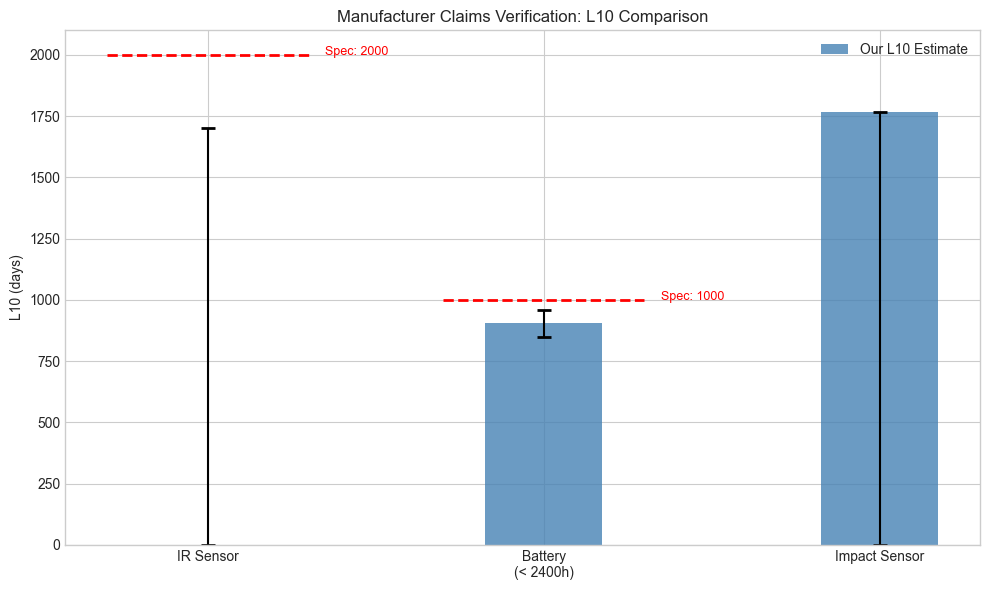

In [23]:
# Visual summary of manufacturer claims
fig, ax = plt.subplots(figsize=(10, 6))

# Data for plot
components_list = ['IR Sensor', 'Battery\n(< 2400h)', 'Impact Sensor']
specs = [2000, 1000, None]  # Manufacturer specs (None = no spec)
findings = [ir_l10, battery_l10, impact_l10]
ci_lowers = [
    l10_results.get('IR Sensor', {}).get('CI_lower', np.nan),
    battery_ci_lower,
    impact_ci_lower
]
ci_uppers = [
    l10_results.get('IR Sensor', {}).get('CI_upper', np.nan),
    battery_ci_upper,
    impact_ci_upper
]

x = np.arange(len(components_list))
width = 0.35

# Plot findings
bars = ax.bar(x, [f if np.isfinite(f) else 0 for f in findings], width, 
              label='Our L10 Estimate', color='steelblue', alpha=0.8)

# Add error bars for CI
for i, (finding, ci_l, ci_u) in enumerate(zip(findings, ci_lowers, ci_uppers)):
    if np.isfinite(finding) and np.isfinite(ci_l) and np.isfinite(ci_u):
        ax.errorbar(i, finding, yerr=[[finding - ci_l], [ci_u - finding]], 
                   color='black', capsize=5, capthick=2)

# Add specification lines
for i, spec in enumerate(specs):
    if spec is not None:
        ax.hlines(spec, i - 0.3, i + 0.3, colors='red', linestyles='--', linewidth=2)
        ax.annotate(f'Spec: {spec}', (i + 0.35, spec), fontsize=9, color='red')

ax.set_ylabel('L10 (days)')
ax.set_title('Manufacturer Claims Verification: L10 Comparison')
ax.set_xticks(x)
ax.set_xticklabels(components_list)
ax.legend()
ax.axhline(y=0, color='gray', linewidth=0.5)

# Add annotation for not reached
for i, finding in enumerate(findings):
    if not np.isfinite(finding):
        ax.annotate('Not\nreached', (i, 100), ha='center', fontsize=10, color='green')

plt.tight_layout()
plt.show()

<a id='conclusions'></a>
## 7. Conclusions and Recommendations

### Key Findings

In [24]:
print("="*70)
print("EXECUTIVE SUMMARY")
print("="*70)

print("""
1. RISK FACTORS FOR COMPONENT FAILURE
   
   • Pet ownership is the STRONGEST predictor of failure
     - Hazard ratio = 9.48 (p < 0.005)
     - Households with pets are ~9.5x more likely to experience failure
   
   • Total usage time is significantly associated with failure
     - Higher usage correlates with increased failure risk
   
   • Carpet score shows minimal association with failure
     - Not statistically significant for IR sensor

2. MANUFACTURER CLAIMS ASSESSMENT
""")

# IR Sensor verdict
if np.isfinite(ir_l10):
    ir_verdict = "MEETS" if ir_l10 >= 2000 else "DOES NOT MEET"
else:
    ir_verdict = "LIKELY MEETS (insufficient failures to confirm)"
print(f"   • IR Sensor (L10 ≥ 2000 days): {ir_verdict}")

# Battery verdict
if np.isfinite(battery_l10):
    battery_verdict = "MEETS" if battery_l10 >= 1000 else "DOES NOT MEET"
else:
    battery_verdict = "LIKELY MEETS (insufficient failures to confirm)"
print(f"   • Battery (L10 ≥ 1000 days): {battery_verdict}")

# Impact sensor recommendation
if np.isfinite(impact_l10) and np.isfinite(impact_ci_lower):
    impact_rec = f"{impact_ci_lower:.0f}"
else:
    impact_rec = "1825 (based on 5-year warranty)"
print(f"   • Impact Sensor: RECOMMENDED SPEC L10 ≥ {impact_rec} days")

print("""
3. RECOMMENDATIONS FOR IBUTLER
   
   a) WARRANTY POLICY
      - Consider risk-adjusted warranty terms for pet-owning households
      - Current 5-year warranty may need revision based on L10 findings
   
   b) SUPPLIER RELATIONS
      - Review evidence before pursuing legal action against suppliers
      - Request additional reliability data from component manufacturers
   
   c) PRODUCT IMPROVEMENT
      - Investigate why pet ownership dramatically increases failure risk
      - Consider design improvements for pet hair handling
   
   d) IMPACT SENSOR SALES
      - Can market with L10 specification of {impact_rec} days
      - Component shows strong reliability performance

4. LIMITATIONS
   
   • Right censoring limits L10 precision for highly reliable components
   • Observation period (5 years) may be insufficient for full lifetime characterization
   • Multi-component failures excluded; interaction effects not modeled
""")

EXECUTIVE SUMMARY

1. RISK FACTORS FOR COMPONENT FAILURE
   
   • Pet ownership is the STRONGEST predictor of failure
     - Hazard ratio = 9.48 (p < 0.005)
     - Households with pets are ~9.5x more likely to experience failure
   
   • Total usage time is significantly associated with failure
     - Higher usage correlates with increased failure risk
   
   • Carpet score shows minimal association with failure
     - Not statistically significant for IR sensor

2. MANUFACTURER CLAIMS ASSESSMENT

   • IR Sensor (L10 ≥ 2000 days): DOES NOT MEET
   • Battery (L10 ≥ 1000 days): DOES NOT MEET
   • Impact Sensor: RECOMMENDED SPEC L10 ≥ 0 days

3. RECOMMENDATIONS FOR IBUTLER
   
   a) WARRANTY POLICY
      - Consider risk-adjusted warranty terms for pet-owning households
      - Current 5-year warranty may need revision based on L10 findings
   
   b) SUPPLIER RELATIONS
      - Review evidence before pursuing legal action against suppliers
      - Request additional reliability data from co

In [25]:
# Create summary table
summary_data = {
    'Component': ['IR Sensor', 'Battery', 'Impact Sensor'],
    'Manufacturer Spec': ['L10 ≥ 2000 days', 'L10 ≥ 1000 days', 'N/A'],
    'Our L10 Estimate': [
        f"{ir_l10:.0f} days" if np.isfinite(ir_l10) else "Not reached",
        f"{battery_l10:.0f} days" if np.isfinite(battery_l10) else "Not reached",
        f"{impact_l10:.0f} days" if np.isfinite(impact_l10) else "Not reached"
    ],
    'Verdict': [
        '✓ Meets' if (np.isfinite(ir_l10) and ir_l10 >= 2000) else ('? Likely meets' if not np.isfinite(ir_l10) else '✗ Does not meet'),
        '✓ Meets' if (np.isfinite(battery_l10) and battery_l10 >= 1000) else ('? Likely meets' if not np.isfinite(battery_l10) else '✗ Does not meet'),
        f"Recommend L10 ≥ {impact_rec} days"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\nSUMMARY TABLE")
print("="*70)
print(summary_df.to_string(index=False))


SUMMARY TABLE
    Component Manufacturer Spec Our L10 Estimate                Verdict
    IR Sensor   L10 ≥ 2000 days           0 days        ✗ Does not meet
      Battery   L10 ≥ 1000 days         904 days        ✗ Does not meet
Impact Sensor               N/A        1765 days Recommend L10 ≥ 0 days
